In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('final_dataset.csv')
df.head()  

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,operatingCashFlowSalesRatio,payablesTurnover,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Readability
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.058638,3.906655,1.514332,1.045610,1.820804,1.225888,0.216333,0.450694,0.946458,10.72
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.067239,4.002846,2.379140,0.875523,1.617815,1.427484,0.209364,0.399695,0.590027,10.31
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,03-06-2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.074426,3.483510,2.555911,0.778754,1.757188,1.357827,0.139776,0.399361,0.459265,10.48
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,0.028394,4.581150,2.580837,1.275586,1.483239,1.216256,0.148324,0.355977,0.504301,11.19
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.058065,3.857790,1.231846,1.154046,2.035788,0.635373,0.207469,0.414938,0.920643,11.21


In [17]:
def group_ratings(rating):
    if rating in ['AAA', 'AA']:
        return 'AA+'
    elif rating in ['CCC' , 'C' , 'D' , 'CC']:
        return 'CCC–'
    else:
        return rating

df['Rating'] = df['Rating'].apply(group_ratings)

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Sector'] = label_encoder.fit_transform(df['Sector'])

label_encoder2 = LabelEncoder()
df['Symbol'] = label_encoder2.fit_transform(df['Symbol'])

label_encoder3 = LabelEncoder()
df['Rating'] = label_encoder3.fit_transform(df['Rating'])

In [19]:
df.drop(["Name" , "Date" , "Rating Agency Name"] , axis = 1 , inplace = True)

In [20]:
columns_to_standardize = df.columns[1:]
scaler = StandardScaler()
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
df.to_csv('standardized_dataset.csv', index=False)

In [21]:
X = df.drop(["Rating"] , axis = 1)
y = df["Rating"]

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score

In [23]:
def stack_ensemble(X_train,X_test , y_train , y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Define base models
    base_models = [
        ("catboost", CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=False)),
        ("lightgbm", LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6 , verbose = -1)),
        ("random_forest", RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42))
    ]

    stack_train = np.zeros((X_train.shape[0], len(base_models)))
    stack_test = np.zeros((X_test.shape[0], len(base_models)))

    # Stratified K-Folds for base models
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Train each base model and store their predictions for stacking
    for i, (name, model) in enumerate(base_models):
        fold_train = np.zeros((X_train.shape[0],))  
        fold_test = np.zeros((X_test.shape[0], 5)) 

        for j, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
            # Split data using the indices provided by K-Fold
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

            # Fit the model on this fold
            model.fit(X_fold_train, y_fold_train)

            # Predict validation set (for stacking), flatten the predictions to avoid shape mismatch
            fold_train[val_idx] = model.predict(X_fold_val).ravel()

            fold_test[:, j] = model.predict(X_test).ravel()

        stack_train[:, i] = fold_train
        stack_test[:, i] = fold_test.mean(axis=1)

    stacker = LogisticRegression()
    stacker.fit(stack_train, y_train)

    final_predictions = stacker.predict(stack_test)
    return confusion_matrix(y_test, final_predictions)

In [24]:

# # 3. LightGBM
def lightgbm(X_train,X_test , y_train , y_test):
    lightgbm_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3 , verbose = -1)
    lightgbm_model.fit(X_train, y_train)
    y_pred_lightgbm = lightgbm_model.predict(X_test)
    return accuracy_score(y_test, y_pred_lightgbm)

def lightgbm_xt(X_train, X_test, y_train, y_test):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',        # Adjust this for multi-class
        'extra_trees': True,          # Enables extra trees mode
        'num_leaves': 31,
        'learning_rate': 0.05,
        'n_estimators': 100,
        'random_state': 42
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(accuracy_score(y_pred,y_test))
    return confusion_matrix(y_test, y_pred)

# Function for LightGBMLarge (optimized for large datasets)
def lightgbm_large(X_train, X_test, y_train, y_test):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',        # Adjust this for multi-class
        'num_leaves': 255,            # Increased to handle large data
        'learning_rate': 0.01,        # Lower learning rate
        'n_estimators': 1000,         # More trees for larger datasets
        'max_depth': -1,              # Allow deeper trees
        'random_state': 42
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(accuracy_score(y_pred,y_test))
    return confusion_matrix(y_test, y_pred)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8678
[LightGBM] [Info] Number of data points in the train set: 1191, number of used features: 35
[LightGBM] [Info] Start training from score -1.537371
[LightGBM] [Info] Start training from score -2.892894
[LightGBM] [Info] Start training from score -2.058668
[LightGBM] [Info] Start training from score -1.473077
[LightGBM] [Info] Start training from score -1.083612
[LightGBM] [Info] Start training from score -3.368977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

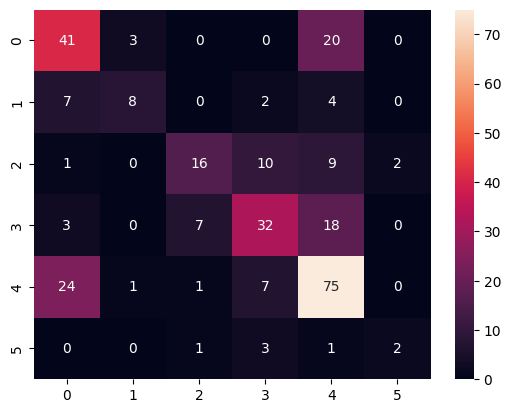

In [25]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# decoded_labels = label_encoder.inverse_transform(encoded_labels.ravel()).reshape(encoded_labels.shape)


def run_model1(X,y):
    X_train,X_test , y_train , y_test = train_test_split(X,y , test_size = 0.2 , random_state = 42)
    sns.heatmap(lightgbm_large(X_train,X_test , y_train , y_test), annot=True)

def run_model2(X,y):
    X_train,X_test , y_train , y_test = train_test_split(X,y , test_size = 0.2 , random_state = 42)
    sns.heatmap(lightgbm_xt(X_train,X_test , y_train , y_test),annot=True)

run_model1(X,y) 


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 1191, number of used features: 27
[LightGBM] [Info] Start training from score -1.537371
[LightGBM] [Info] Start training from score -2.892894
[LightGBM] [Info] Start training from score -2.058668
[LightGBM] [Info] Start training from score -1.473077
[LightGBM] [Info] Start training from score -1.083612
[LightGBM] [Info] Start training from score -3.368977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.6140939597315436


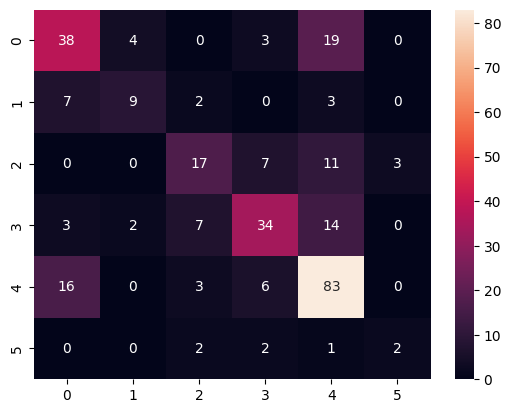

In [26]:
X = X.drop(["Negative","Positive","Uncertainty","Litigious","Strong_Modal","Weak_Modal","Constraining","Readability"] ,axis = 1)
run_model2(X ,y)   # no nlp extracted featurres used 

In [27]:
X = df.drop(["Symbol" , "Rating"] , axis=1)
X

,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,netProfitMargin,pretaxProfitMargin,grossProfitMargin,operatingProfitMargin,returnOnAssets,...,operatingCashFlowSalesRatio,payablesTurnover,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Readability
0,-0.824698,-0.060702,-0.068602,-0.147666,-0.069133,-0.039618,-0.042436,-0.542408,-0.045665,-0.023516,...,-0.064850,-0.051142,0.175272,0.913171,0.810471,0.859724,0.165990,0.289363,0.945833,-0.046131
1,-0.824698,-0.058993,-0.066727,-0.122688,-0.070148,-0.038469,-0.042492,-0.543984,-0.045225,0.083880,...,-0.064444,-0.051033,1.513844,0.358279,0.483632,1.224594,0.112018,0.092125,-0.070330,-0.120508
2,-0.824698,-0.060354,-0.067947,-0.142254,-0.067839,-0.040450,-0.043002,-0.552371,-0.045816,-0.101211,...,-0.064104,-0.051620,1.787455,0.042578,0.708041,1.098523,-0.426932,0.090832,-0.443123,-0.089669
3,-0.824698,-0.059260,-0.066409,-0.129210,-0.069725,-0.042511,-0.049447,-0.608807,-0.047332,-0.162053,...,-0.066280,-0.050380,1.826036,1.663444,0.266948,0.842292,-0.360732,-0.076955,-0.314728,0.039130
4,-0.824698,-0.060469,-0.066800,-0.137543,-0.068440,-0.038679,-0.041938,-0.540533,-0.045329,0.022738,...,-0.064877,-0.051197,-0.261966,1.266931,1.156623,-0.209053,0.097338,0.151075,0.872238,0.042758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,-0.247506,-0.062334,-0.060920,-0.103684,-0.058651,-0.031991,-0.033816,0.207196,-0.039406,0.330222,...,-0.060071,-0.053110,0.238057,-0.868995,-0.279192,0.356966,-0.383560,0.233033,-0.364923,-0.100553
1485,-0.247506,-0.070177,-0.072790,-0.132299,-0.073858,-0.053630,-0.052939,0.336376,-0.035662,-0.465358,...,-0.049598,-0.036578,-1.357740,-0.503985,0.514840,-0.726876,0.181169,0.150374,-1.005653,0.200582
1486,0.041090,-0.059908,-0.056577,-0.147423,-0.072486,-0.032349,-0.037929,0.874956,-0.043233,0.072904,...,-0.064140,-0.055555,-2.168651,-2.498032,5.473689,-1.359020,-1.509481,2.194898,-1.752461,0.793781
1487,-1.113294,0.149986,0.106042,1.532614,-0.077536,-0.036264,-0.038264,0.874956,-0.044238,0.228005,...,-0.063698,-0.037754,0.691317,0.058365,0.324231,1.109753,0.138841,-0.593175,0.122976,0.215094


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8427
[LightGBM] [Info] Number of data points in the train set: 1191, number of used features: 34
[LightGBM] [Info] Start training from score -1.537371
[LightGBM] [Info] Start training from score -2.892894
[LightGBM] [Info] Start training from score -2.058668
[LightGBM] [Info] Start training from score -1.473077
[LightGBM] [Info] Start training from score -1.083612
[LightGBM] [Info] Start training from score -3.368977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

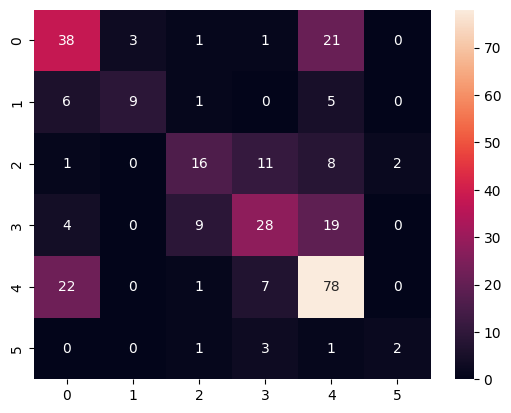

In [28]:
run_model1(X,y) # nlp extracted features used 


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6387
[LightGBM] [Info] Number of data points in the train set: 1191, number of used features: 26
[LightGBM] [Info] Start training from score -1.537371
[LightGBM] [Info] Start training from score -2.892894
[LightGBM] [Info] Start training from score -2.058668
[LightGBM] [Info] Start training from score -1.473077
[LightGBM] [Info] Start training from score -1.083612
[LightGBM] [Info] Start training from score -3.368977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

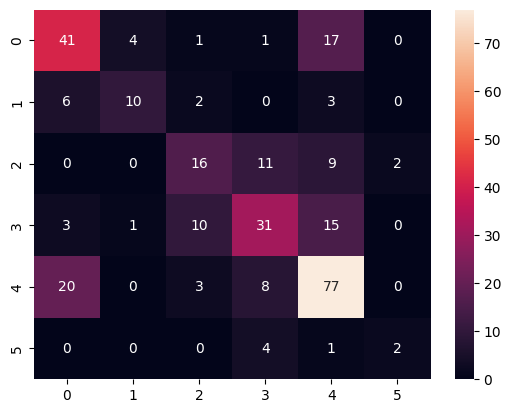

In [29]:
X = X.drop(["Negative","Positive","Uncertainty","Litigious","Strong_Modal","Weak_Modal","Constraining","Readability"] ,axis = 1)
run_model1(X ,y)   # no nlp extracted features used 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6387
[LightGBM] [Info] Number of data points in the train set: 1191, number of used features: 26
[LightGBM] [Info] Start training from score -1.537371
[LightGBM] [Info] Start training from score -2.892894
[LightGBM] [Info] Start training from score -2.058668
[LightGBM] [Info] Start training from score -1.473077
[LightGBM] [Info] Start training from score -1.083612
[LightGBM] [Info] Start training from score -3.368977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.5838926174496645


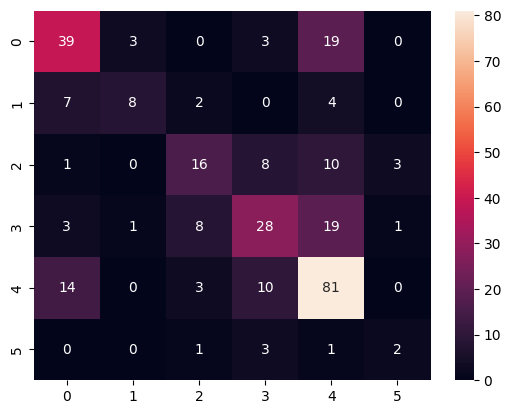

In [30]:
run_model2(X ,y)   # no nlp extracted features used 